# Advanced Lane Finding Project

**The goals / steps of this project are the following:**

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [44]:
'''Importing all the necessary packages'''
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import matplotlib.image as mpimg
import glob

## Keeping all required functions at one place 
### (so that we can look at the pipeline just like a story without worrying much about what's happening inside)

In [45]:
# Function to diplay the process from original image to representation of lane lines 
def display(img1, img2, img3, img4, label1, label2, label3, label4):
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title(label1, fontsize=30)
    ax2.imshow(img2)
    ax2.set_title(label2, fontsize=30)
    ax3.imshow(img3)
    ax3.set_title(label3, fontsize=30)
    ax4.imshow(img4)
    ax4.set_title(label4, fontsize=30)
    img5 = img4
    ax5.imshow(img5)
    ax5.set_title('Lane Lines', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

# This function will remove distortion from the image
def remove_dist(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


# Function which thresholds S channel of HLS image and returns binary output
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output


# Function that applies Sobel x or y, then takes an absolute value and applies a threshold.
def sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel))
        
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output


# Function that applies Sobel x and y, then computes the magnitude of the gradient and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return binary_output


# function that applies Sobel x and y, then computes the direction of the gradient and applies a threshold.
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output

# function combining all the thresholds
def binary_acc_to_combined_threshold(image):
    grad_binary = sobel_thresh(image, orient='x', sobel_kernel=3, thresh_min=30, thresh_max=100)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30,100))
    dir_binary = dir_thresh(image, sobel_kernel=3, thresh=(0.7, 1.4))
    
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(grad_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    hls_binary = hls_select(image, thresh=(170, 255))

    combined = np.zeros_like(combined_binary)
    combined[(hls_binary == 1) | (combined_binary == 1)] = 1

    color_binary = np.dstack(( np.zeros_like(hls_binary), combined_binary, hls_binary)) * 255

    return combined, color_binary


# function which warps the image according to source & destination points
def transform_image(img):     
    img_size = (img.shape[1], img.shape[0])
    offset = 100

    left_top  = [568,470]
    right_top = [720,470]
    left_bottom  = [260,680]
    right_bottom = [1050,680]

    src = np.float32([left_top, left_bottom, right_top, right_bottom])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)

    return warped, M


# finding lane line pixels present in warped image
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]//2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
    nwindows = 9
    margin = 100
    minpix = 30

    window_height = np.int(binary_warped.shape[0]//nwindows)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),
#         (win_xleft_high,win_y_high),(0,255,0), 2) 
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),
#         (win_xright_high,win_y_high),(0,255,0), 2) 
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


# function which takes left lane coefficients and right lane coefficients from previous frame in video instead of 
# calculationg coefficients again for current frame
def fit_polynomial_from_prev(left_fit, right_fit, binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
     
    return left_fit_new, right_fit_new


# function which calculates coefficients of lane lines for current frame
def fit_polynomial(binary_warped):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    plt.imshow(out_img)
    
    return out_img, left_fit, right_fit


# function which measures radius of curvature for both frames in metres
def measure_curvature_real(warped, left_fit_cr, right_fit_cr):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    left_bottom = (left_fit_cr[0]*y_eval)**2 + left_fit_cr[0]*y_eval + left_fit_cr[2]
    right_bottom = (right_fit_cr[0]*y_eval)**2 + right_fit_cr[0]*y_eval + right_fit_cr[2]
    
    lane_center = (left_bottom + right_bottom)/2.
    frame_center = 640
    center = (lane_center - frame_center)*xm_per_pix
    
    return left_curverad, right_curverad, center


# function which unwarps the image back into its original shape and fills the region between the lane lines in image
def visualisation(warped, left_fit, right_fit, image, undist, lc, rc, center):
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    Minv = np.linalg.inv(M)

    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(lc), (50, 50), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(rc), (50, 100), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    cv2.putText(result, 'Center offset: {:.4f} m'.format(center), (50, 150), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 255, 255), 2)
    
    return result

## Camera Calibartion

In [46]:
nx = 9
ny = 6
objpoints = []
imgpoints = []
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

images = glob.glob("camera_cal/calibration*.jpg")

for image in images:
    img = mpimg.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Saving an example of calibrated image with distortion removed in **'camera_cal_output'** folder

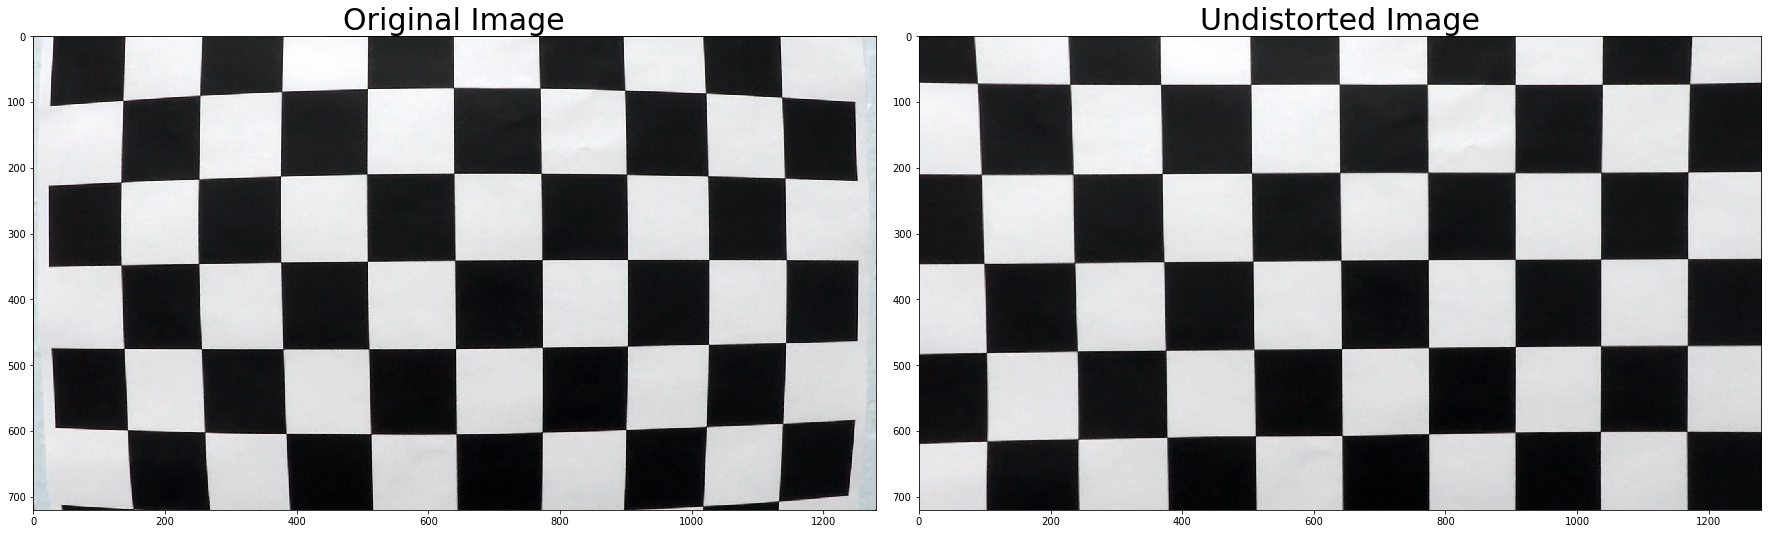

In [47]:
img = cv2.imread('camera_cal/calibration1.jpg')
undist = remove_dist(img, mtx, dist)
cv2.imwrite("camera_cal_output/calibration.jpg",undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Pipeline for test images

**This pipeline will perform following steps and keep saving intermediate results in respective folders as mentioned in code**

* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


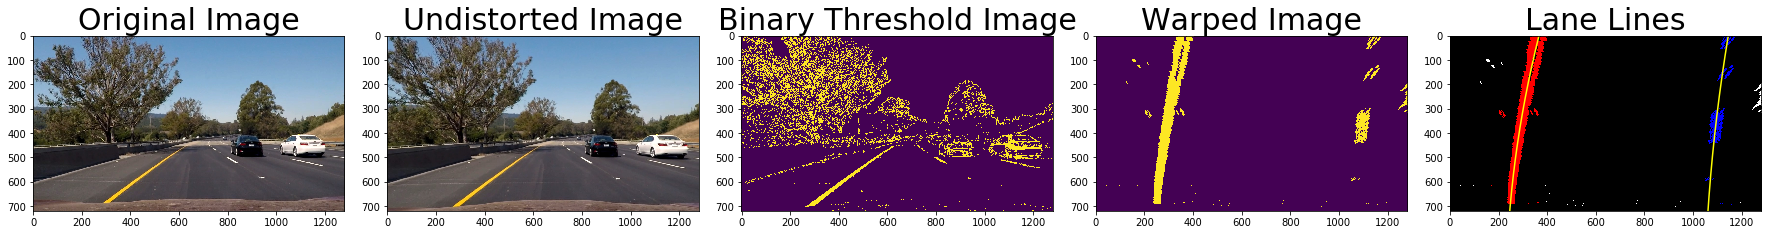

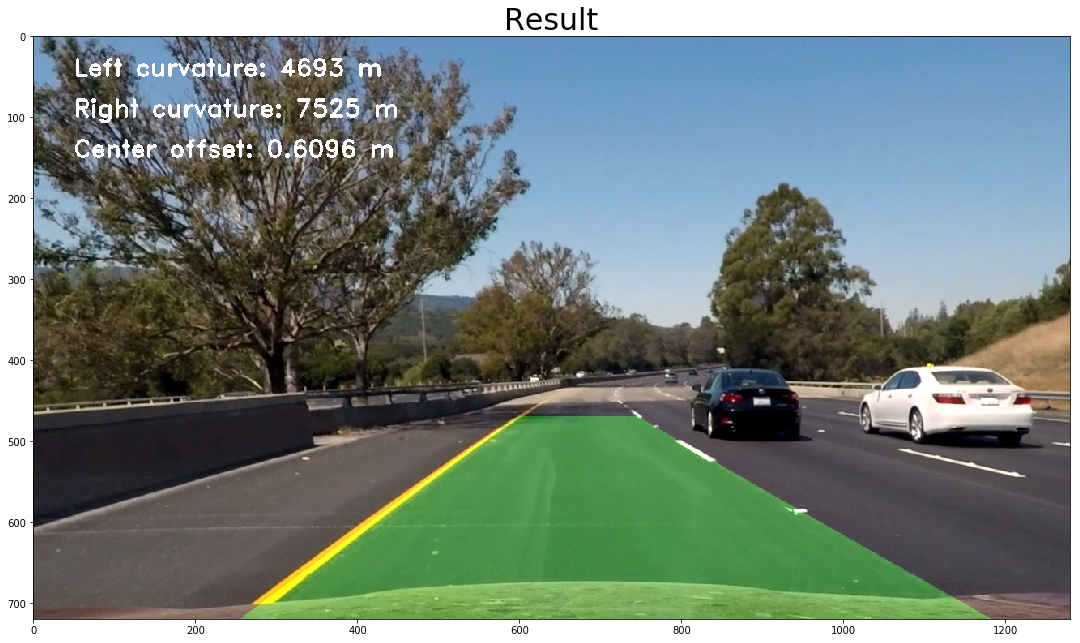

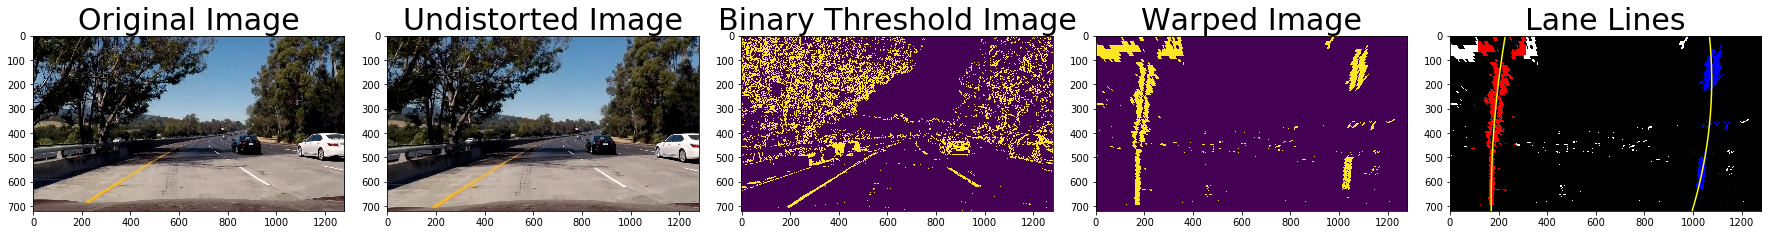

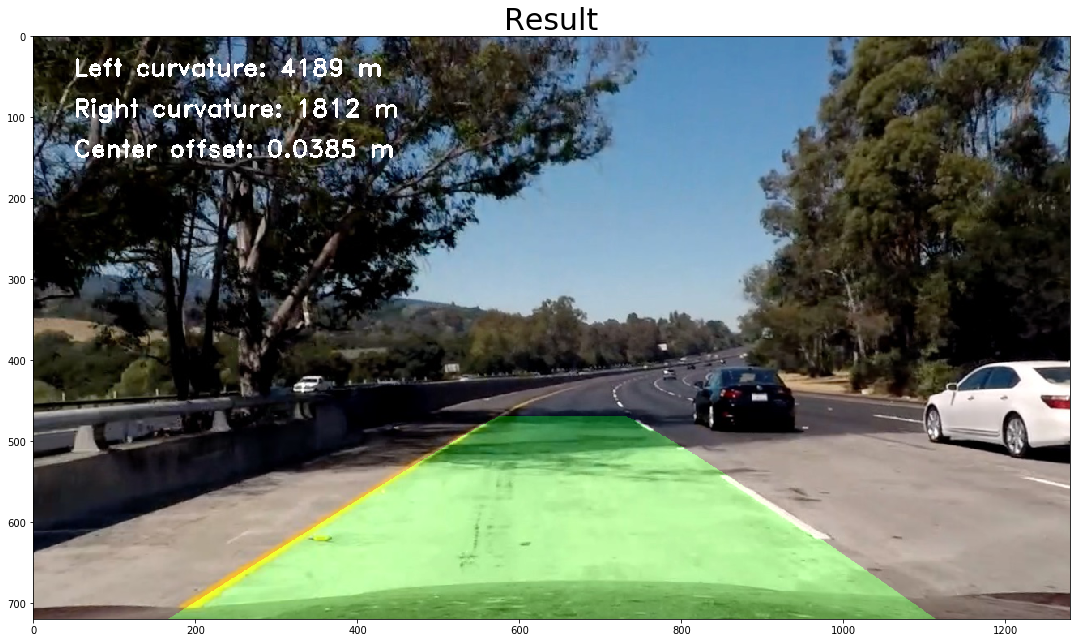

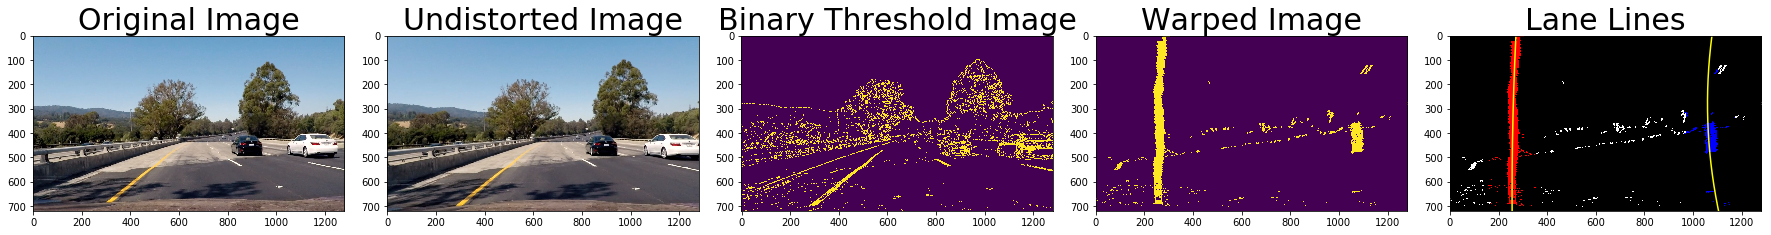

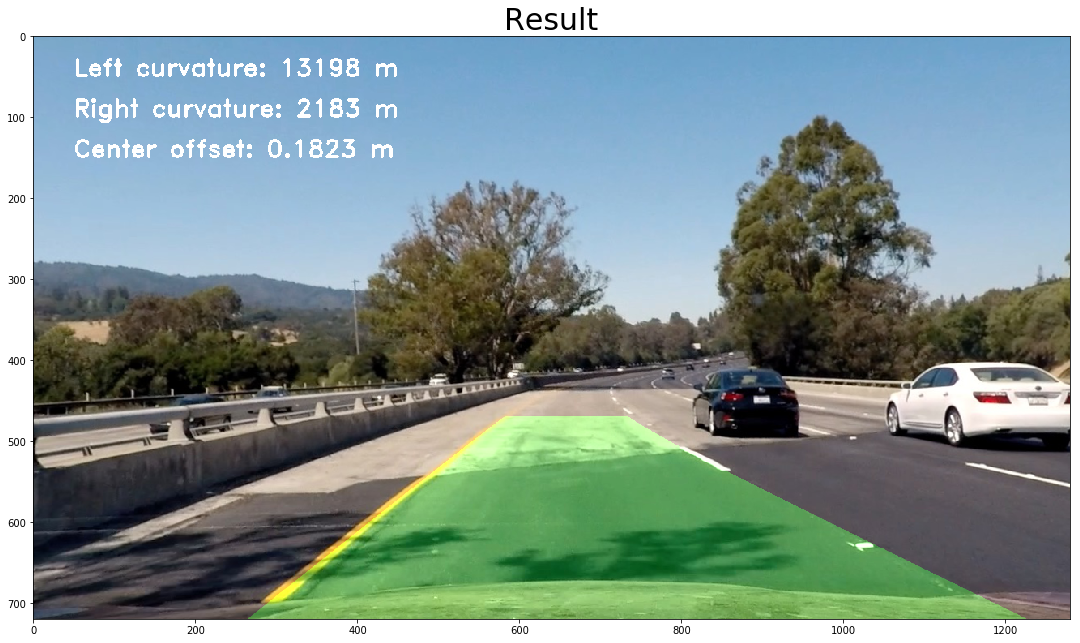

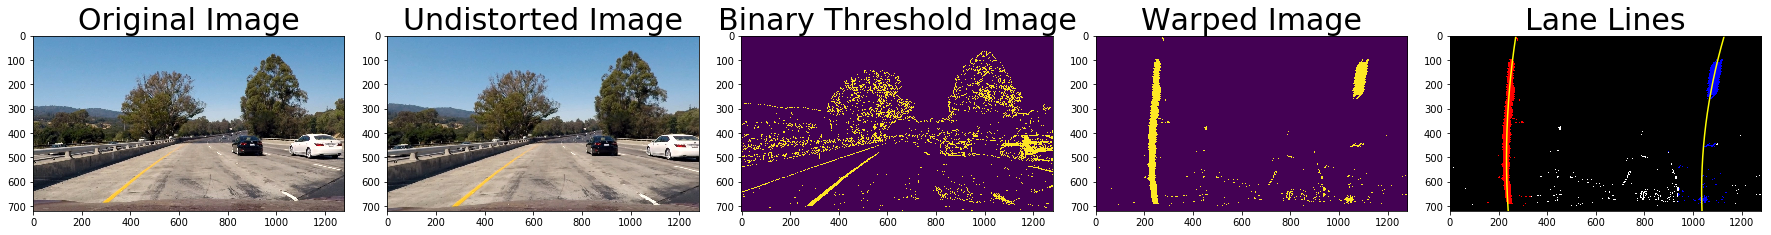

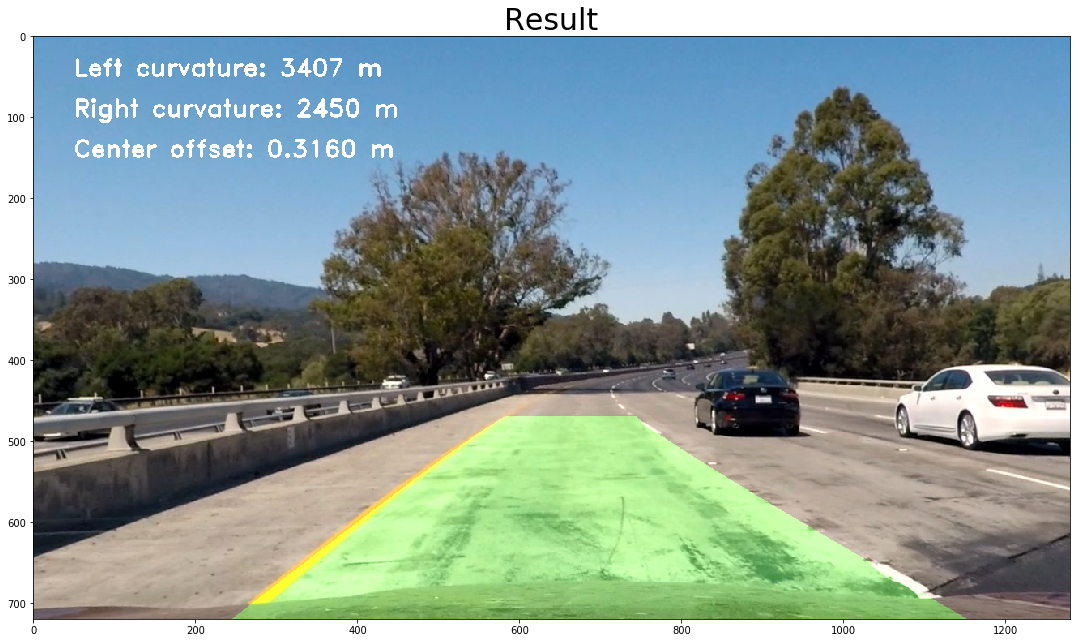

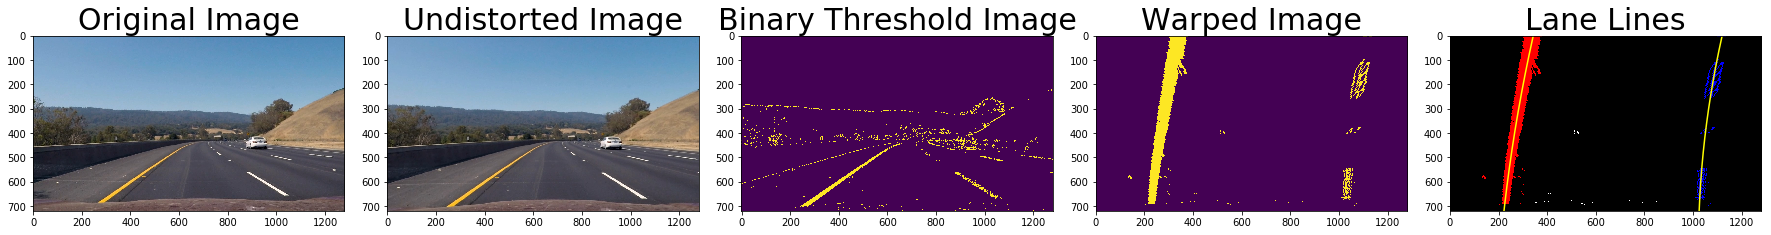

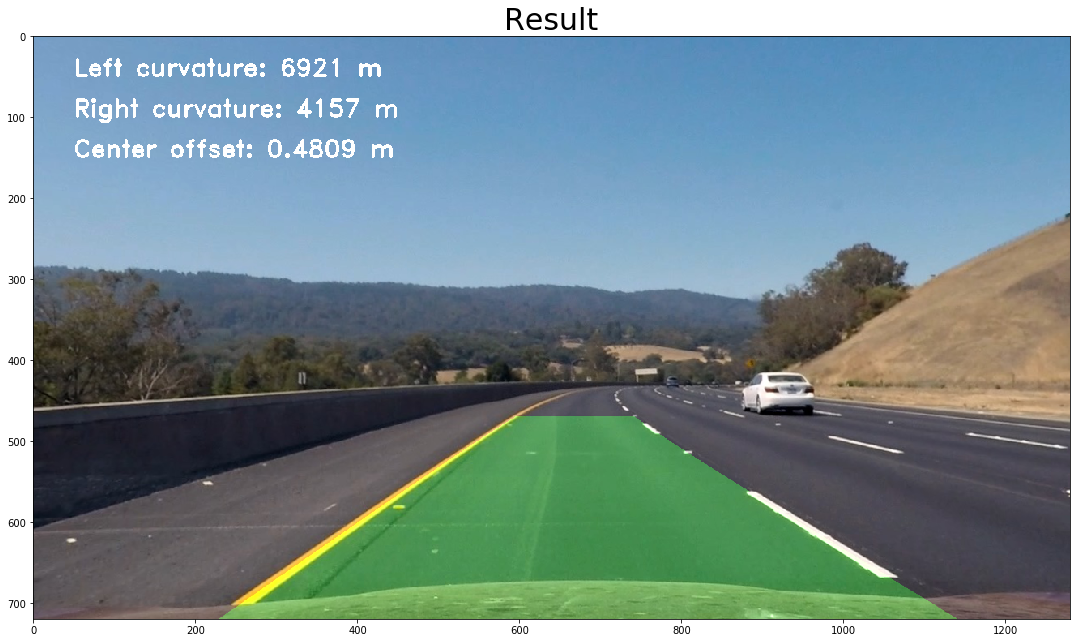

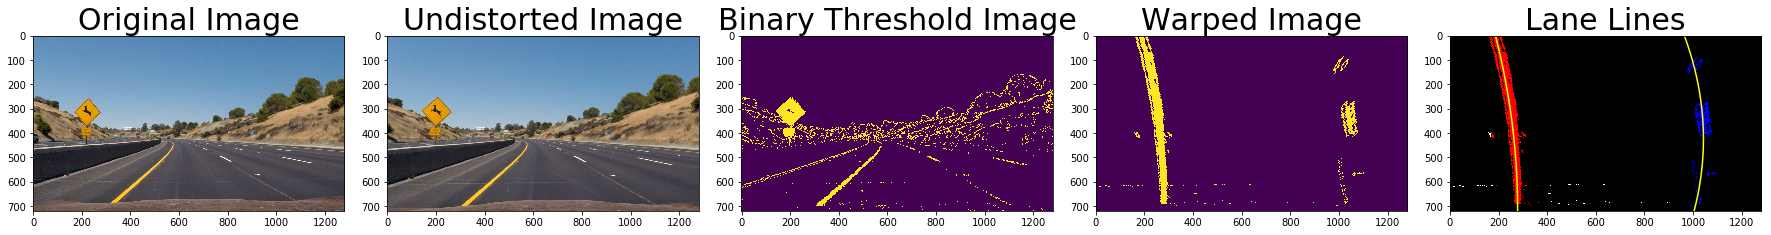

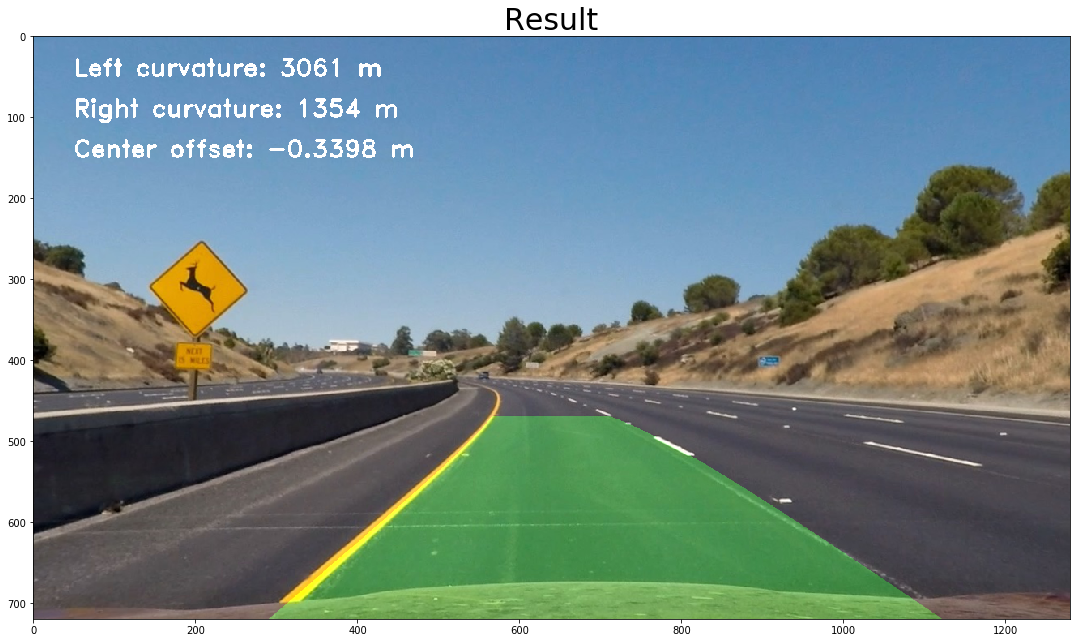

In [48]:
images = glob.glob("test_images/test*.jpg")

for image in images:
    file_name = image.split('/')[1]
    image = mpimg.imread(image)
    
    undist = remove_dist(image, mtx, dist)
    undistorted = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
    cv2.imwrite("output_images_undistorted/" + file_name,undistorted)
    
    combined, color_binary = binary_acc_to_combined_threshold(undist)
    cv2.imwrite("output_images_binary/" + file_name,color_binary)
    
    warped, M = transform_image(combined)
    cv2.imwrite("output_images_bird_view/" + file_name,warped)
    
    display(image,undist,combined,warped,'Original Image','Undistorted Image','Binary Threshold Image','Warped Image')
    
    out_img, left_fit, right_fit = fit_polynomial(warped)
    cv2.imwrite("output_images_lane_lines/" + file_name,out_img)
    
    lc, rc, center = measure_curvature_real(warped, left_fit, right_fit)

    result = visualisation(warped, left_fit, right_fit, image, undist, lc, rc, center)
    
    f, (ax1) = plt.subplots(1, 1, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(result)
    ax1.set_title('Result', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Functions and class required for video pipeline 

In [49]:
# this class will be used to store important information from previous frame in video 
class Lane():
    def __init__(obj):
        obj.left_fit = None
        obj.right_fit = None
        obj.left_fit_prev = None
        obj.right_fit_prev = None
        obj.counter = 0
        obj.reset = 0
        

# function tells whether coefficients deduced for current frame are reliable for drawing lane lines or not
'''Here I first calculate the left and right x coordinates at bottom of the frame from where lane lines will start
using the lane line coefficients deduced'''
'''Then I check the distance between these x coordinates which if significantly less will result in lane lines which
are much closer to each other than they should be'''
def is_good_to_go(left_fit, right_fit):
    
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        ploty = np.linspace(0, 30, num=10 )
        y = 680
        left_fitx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
        right_fitx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
        diff = np.absolute(right_fitx - left_fitx)

        if diff < 700:
            status = False
        else:
            status = True
            
    return status

'''VIDEO PIPELINE'''
def process_image(image):
    
    undist = remove_dist(image, mtx, dist)
    combined, color_binary = binary_acc_to_combined_threshold(undist)
    warped, M = transform_image(combined)
    
    if lane.counter==0:
        out_img, lane.left_fit, lane.right_fit = fit_polynomial(warped)
    else:
        lane.left_fit, lane.right_fit = fit_polynomial_from_prev(lane.left_fit, lane.right_fit, warped)
            
    status = is_good_to_go(lane.left_fit, lane.right_fit)
    
    if status==True:
        lane.left_fit_prev,lane.right_fit_prev = lane.left_fit, lane.right_fit
        lane.counter += 1
    else:
        lane.left_fit, lane.right_fit = lane.left_fit_prev, lane.right_fit_prev
        
    lc, rc, c = measure_curvature_real(warped, lane.left_fit, lane.right_fit)
    result = visualisation(warped, lane.left_fit, lane.right_fit, image, undist, lc, rc, c)
        
    return result


## Applying the pipeline on video and storing the output in 'output_video' folder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[MoviePy] >>>> Building video output_video/project_video_output.mp4
[MoviePy] Writing video output_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:12<00:00,  6.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video_output.mp4 

CPU times: user 5min 43s, sys: 36.8 s, total: 6min 20s
Wall time: 3min 13s


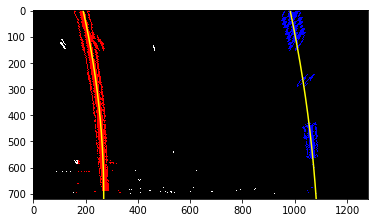

In [50]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane = Lane()

output = 'output_video/project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
out_clip = clip1.fl_image(process_image)
%time out_clip.write_videofile(output, audio=False)

## Viewing the output video in notebook itself

In [51]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))